# Notebook for assignment Responsible AI predictive XAI exercise

In [28]:
import os
import matplotlib.pyplot as plt
import torchvision
import torch
import pandas as pd
import numpy as np

from utils.notebook import display_scrollable_dataframe,plot_sailency
from data_loaders import CUB_extnded_dataset
from models import get_inception_transform
from IPython.display import display

from sailency import get_saliency_maps,saliency_score_part

In [29]:
# Settings for the experiment your running
data_set = 'val' 

id = 0 # The id of the image you want to explain

# Settings for loading the dataset, make sure its the same as the one used to train the model. 
# You can find the settings in the .hydra folders config.yaml 
data_config = {'CUB_dir':r'data/CUB_200_2011',
                'split_file':r'data/train_test_val.pkl',
                'use_majority_voting':True,
                'min_class_count':10,
                'return_visibility':True}



In [30]:
#Define data set, the human transformer data_set is used to get the original images instead of the normalized ones
transformer = get_inception_transform(mode='val',methode="center")
human_tansform = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(299),torchvision.transforms.ToTensor()])

#Get dataset
data = CUB_extnded_dataset(mode=data_set,config_dict=data_config,transform=transformer)

#Get a dataset that return original images instead normalized ones
data_human = CUB_extnded_dataset(mode=data_set,config_dict=data_config,transform=human_tansform)
concept_names = data.consept_labels_names
class_names = data.class_labels_names
n_classes = data.n_classes
n_concepts = data.n_concepts

In [31]:

X, C, Y,coordinates = data.__getitem__(id)

print("Image shape: ",X.shape)
print("Concept shape: ",C.shape)
print("Label shape: ",Y.shape)
X = X.unsqueeze(0)

img ,_,_,_ = data_human.__getitem__(id)

print(Y.argmax())

Image shape:  torch.Size([3, 299, 299])
Concept shape:  torch.Size([112])
Label shape:  torch.Size([200])
tensor(62)


In [32]:
# Separate the concepts and their visibility only relevant if visibility is used and no majority voting is used
if len(C.shape) == 2:
    Concepts = C[0]
    Concepts_visiblity = C[1]
else:
    Concepts = C.tolist()
    Concepts_visiblity = [None]*len(C)

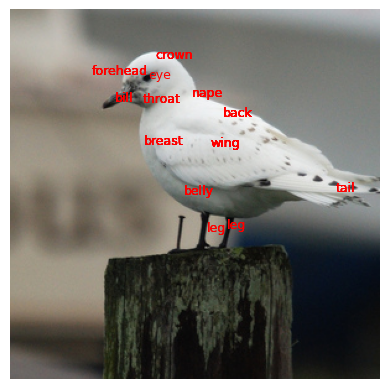

In [33]:
# Show the image and the coordinates of the concepts
plt.imshow(img.permute(1, 2, 0))

for i in range(len(coordinates)):
    if len(coordinates[i]) > 0:
        #print(f'coordinates {coordinates[i]} atribute_locations_names {consept_labels_masked[i]}')
        for x,y in coordinates[i]:
            #plt.plot(x,y,'ro')
            name=concept_names[i].split("_")[1]
            if name == "forehead":
                ofset = -30

            elif name == "eye":
                ofset = 0
            else:
                ofset = 0
            
            plt.text(x+ofset,y,name,fontsize=9,color='red')
    plt.axis('off')
            
plt.size=(50,50)
plt.show()

# Expandability for Sequential and independent models.  

In [34]:
#Load models make sure the model is trained with the same settings as the data loader
model_folder = r"models\Sequential_Basemodel3"

X_to_C_path = os.path.join(r"models\orignal_CtoY\best_model_1.pth")
C_to_Y_path = os.path.join(model_folder,"best_CtoY_model.pth")

ModelXtoC = torch.load(X_to_C_path,map_location=torch.device('cpu')).eval()
ModelCtoY = torch.load(C_to_Y_path,map_location=torch.device('cpu')).eval()

C:\Users\Andre\AppData\Local\Temp\ipykernel_46580\1171770299.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ModelXtoC = torch.load(X_to_C_path,map_location=torch.device

In [35]:
X.shape


torch.Size([1, 3, 299, 299])

In [46]:
#Make prediction

C_hat = ModelXtoC(X)
C_hat = [C for C in C_hat]
C_hat = torch.sigmoid(torch.tensor(C_hat,dtype=torch.float32).unsqueeze(0))
print(C_hat)
Y_hat = ModelCtoY(C_hat)

print(f"Predicted class: {Y_hat.argmax().item()} true class: {Y.argmax().item()} probability of true class: {Y_hat[0,Y.argmax()].item()}")

tensor([[5.9478e-05, 9.2891e-05, 1.5716e-04, 2.2590e-05, 3.4964e-05, 7.9051e-05,
         2.9412e-07, 5.1467e-05, 9.9989e-01, 2.4483e-06, 8.5217e-05, 1.0131e-04,
         1.2809e-07, 2.3057e-04, 9.9985e-01, 3.4488e-06, 4.2190e-06, 1.7870e-06,
         9.6871e-06, 6.6725e-05, 9.9972e-01, 8.4197e-06, 9.9966e-01, 7.1892e-07,
         1.6409e-06, 4.3075e-05, 2.7889e-04, 3.4146e-08, 6.5190e-05, 9.9994e-01,
         2.2712e-06, 1.3655e-05, 5.0370e-05, 4.2868e-05, 2.6486e-04, 9.9993e-01,
         1.4456e-06, 1.8454e-06, 9.9987e-01, 5.7475e-06, 2.0013e-06, 3.0783e-06,
         4.4744e-05, 9.9970e-01, 2.5089e-06, 7.7934e-07, 2.7512e-06, 1.0350e-05,
         9.9990e-01, 2.3660e-07, 9.9753e-01, 9.9962e-01, 9.0280e-05, 3.0522e-06,
         9.3706e-06, 2.9102e-07, 3.2107e-07, 1.3847e-04, 9.9998e-01, 2.6077e-05,
         9.4493e-05, 2.5221e-04, 9.9995e-01, 5.7379e-07, 3.1922e-06, 3.3966e-06,
         3.6217e-07, 1.3717e-04, 9.9992e-01, 1.6207e-06, 5.3863e-07, 7.5595e-07,
         1.4854e-06, 4.5272e

In [48]:
#Make Concept prediction and other stuff
weights = ModelCtoY.linear.weight[Y.argmax().item()] #Find the weigths of the bird you guessed on.
Concept_frame = pd.DataFrame({"Concept":concept_names,"Concept_true":Concepts,"Concept_visiblity":Concepts_visiblity,"Concept_pred":np.round(C_hat[0].detach().numpy(),4),"CtoY_weight":weights.detach().numpy()})
display_scrollable_dataframe(Concept_frame)

In [38]:
#List of concepts to plot
concept_list = [51,50,111]

sailency_maps = get_saliency_maps(X,concept_list,ModelXtoC,method_type="vanilla")

plot_sailency(img,sailency_maps,concept_list,concept_names,coordinates)

AttributeError: 'list' object has no attribute 'shape'

# Saliency map for Joint models  

In [11]:
#Load models make sure the model is trained with the same settings as the data loader
model_path = r'models\Joint_Basemodel3\best_Joint_model.pth'
n_classes = data.n_classes
n_concepts = data.n_concepts

#Load the model
Joint_model = torch.load(model_path,map_location=torch.device('cpu'))




C:\Users\Andre\AppData\Local\Temp\ipykernel_43036\961612813.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Joint_model = torch.load(model_path,map_location=torch.device

In [12]:
#Make prediction
C_hat,Y_hat = Joint_model(X)
print(f"Predicted class: {Y_hat.argmax().item()} true class: {Y.argmax().item()} probability of true class: {Y_hat[0,Y.argmax()].item()}")

Predicted class: 86 true class: 86 probability of true class: 0.5894005298614502


In [13]:
#Make Concept prediction and other stuff
weights = Joint_model.MLP_model.linear.weight[Y.argmax().item()]
Concept_frame = pd.DataFrame({"Concept":concept_names,"Concept_true":Concepts,"Concept_visiblity":Concepts_visiblity,"Concept_pred":np.round(C_hat[0].detach().numpy(),2),"CtoY_weight":weights.detach().numpy()})
display_scrollable_dataframe(Concept_frame)

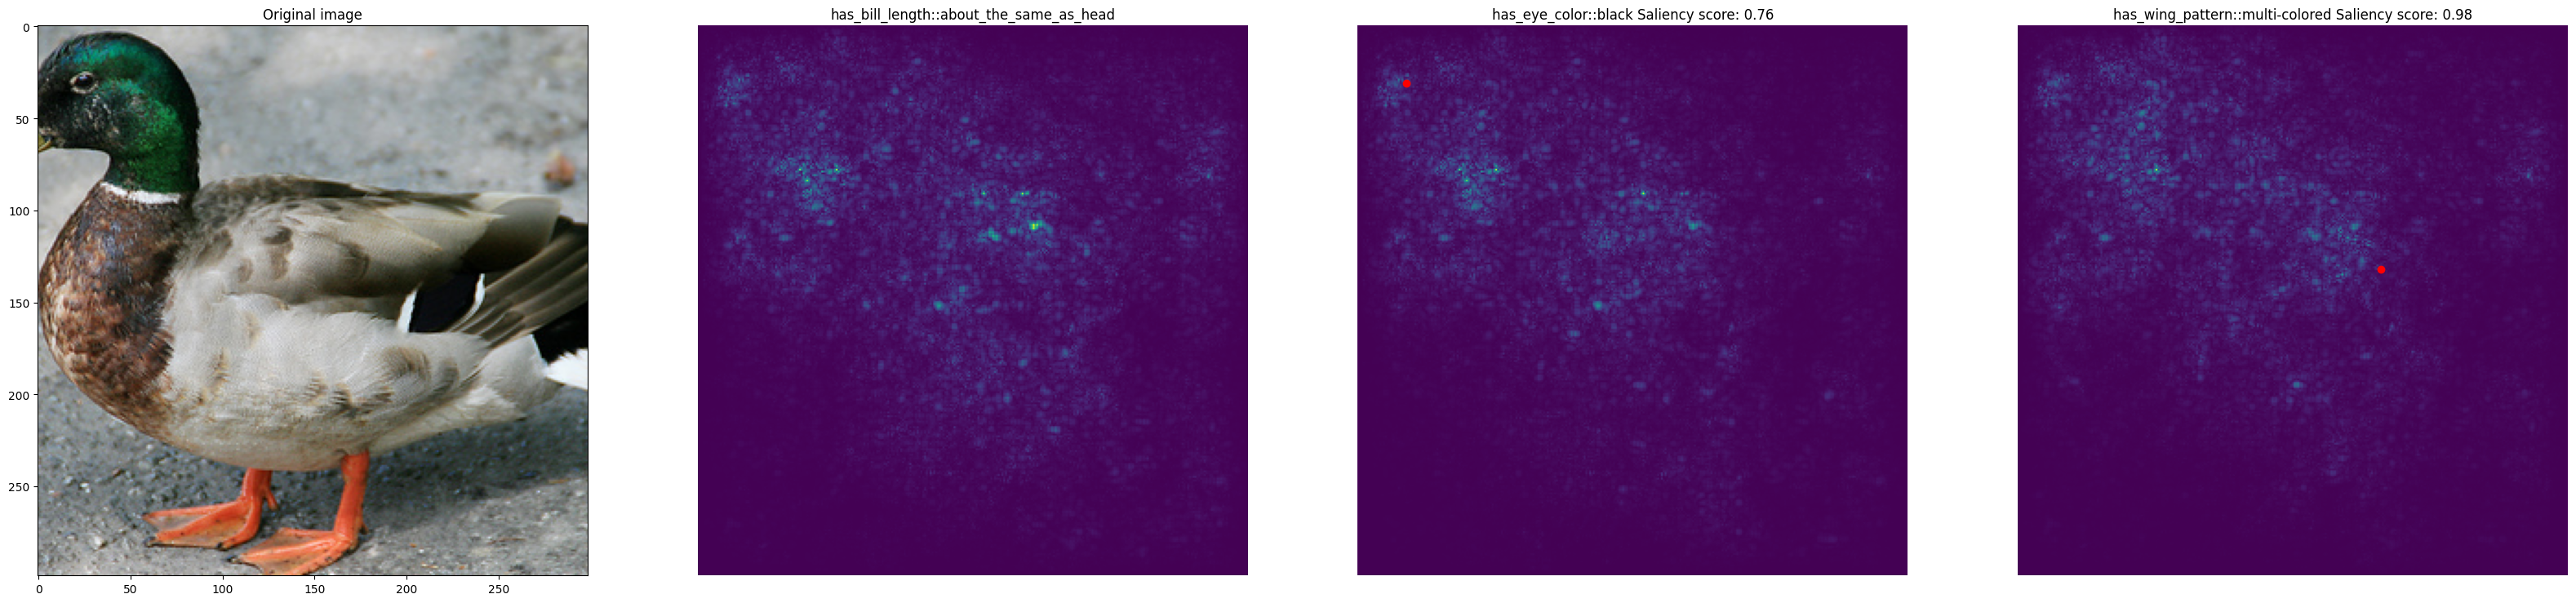

In [14]:
concept_list = [51,50,111]

#Make model only predict the concept C
Joint_model.set_sailency_output("C")

sailency_maps = get_saliency_maps(X,concept_list,Joint_model,method_type="vanilla")

plot_sailency(img,sailency_maps,concept_list,concept_names,coordinates)

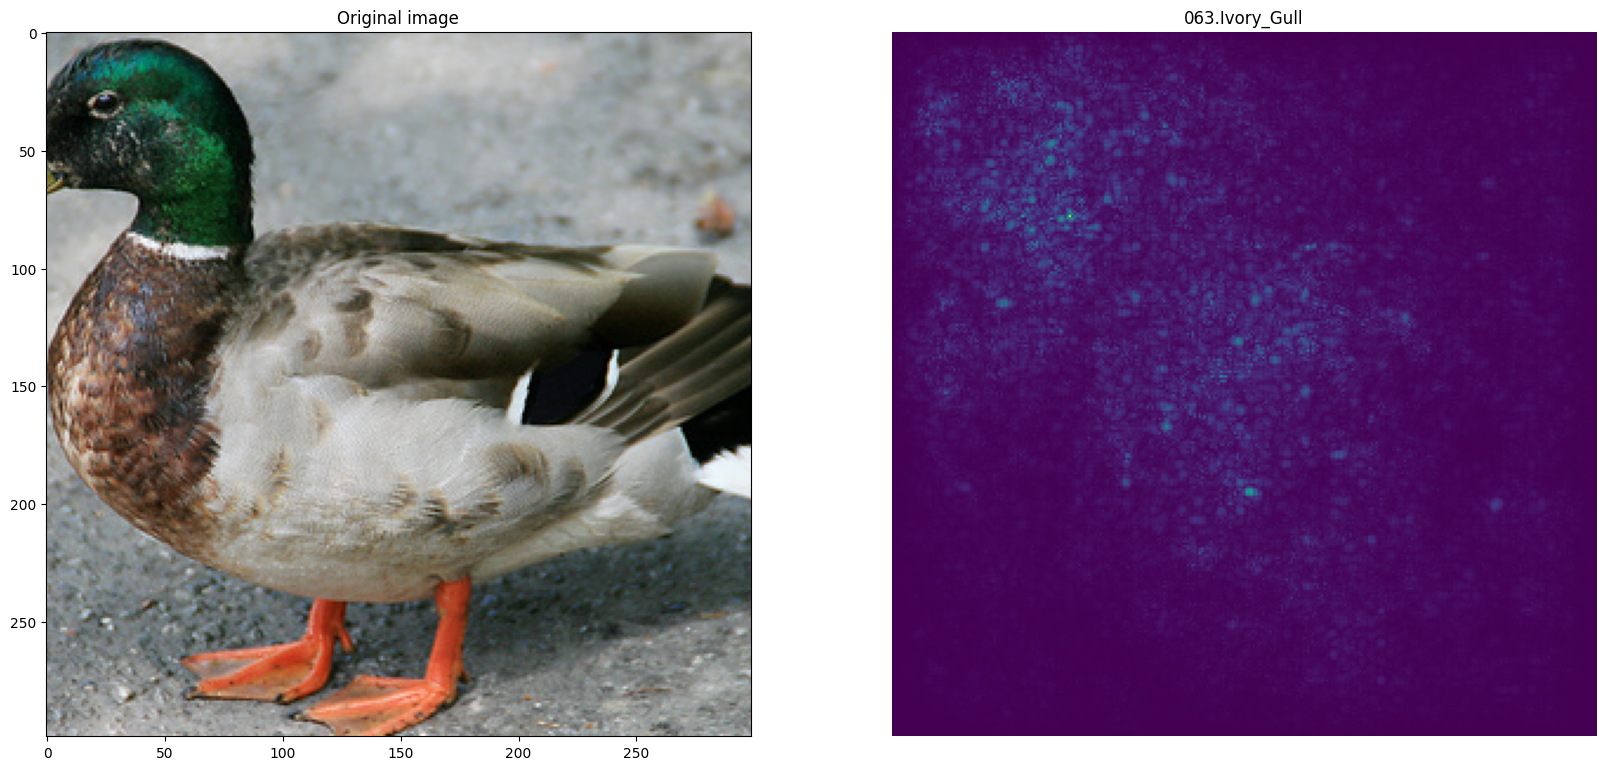

In [15]:
concept_list = [62]

#Make model only predict the concept C
Joint_model.set_sailency_output("Y")

sailency_maps = get_saliency_maps(X,concept_list,Joint_model,method_type="vanilla")

plot_sailency(img,sailency_maps,concept_list,class_names)